## Gather satellite data

In [1]:
pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 16.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akhilchibber/deforestation-detection-dataset")

print("Path to dataset files:", path)

/home/epele/micromamba/envs/license/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 10.1G/10.1G [04:43<00:00, 38.3MB/s]  

Extracting files...


Path to dataset files: /home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1


In [3]:
pip install matplotlib numpy scikit-image rasterio tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 88.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 92.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.io import imread
from skimage.transform import resize
import rasterio
import tensorflow as tf
from tensorflow.keras.utils import normalize
from pathlib import Path
from sklearn.model_selection import train_test_split

2025-03-26 18:11:16.906347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 18:11:17.097060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743005477.169504    1994 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743005477.187579    1994 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743005477.351673    1994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Label loading

In [6]:
import os

data_dir = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset'
for root, dirs, files in os.walk(data_dir):
    print("Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)
    print()

Directory: /home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset
Subdirectories: ['versions']
Files: ['1.complete']

Directory: /home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions
Subdirectories: ['1']
Files: []

Directory: /home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1
Subdirectories: ['3_TRAINING_MASKS', '2_CLOUDY_DATASET', '1_CLOUD_FREE_DATASET']
Files: []

Directory: /home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/3_TRAINING_MASKS
Subdirectories: ['MASK_16_GRID', 'MASK_FULL']
Files: ['Readme.txt']

Directory: /home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/3_TRAINING_MASKS/MASK_16_GRID
Subdirectories: []
Files: ['RASTER_9.tif', 'RASTER_2.tif', 'RASTER_1.tif', 'RASTER_15.tif', 'RASTER_3.tif', 'RASTER_14.tif', 'RASTER_0.tif', 'RASTER_12.tif', 'RASTER_13.tif', 'RASTER_10.tif', 'RA

Deforestation imagery

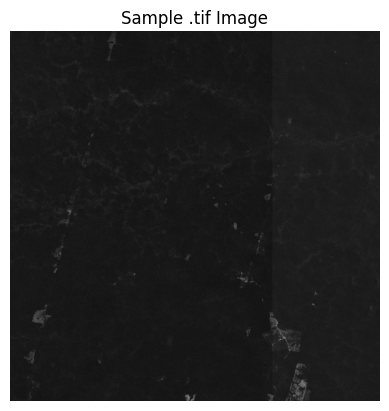

In [8]:
import rasterio
import matplotlib.pyplot as plt

# Path to a sample .tif file
tif_file = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/RASTER_0.tif'

# Open and display the image
with rasterio.open(tif_file) as src:
    image = src.read(1)  # Read the first band
    plt.imshow(image, cmap='gray')
    plt.title("Sample .tif Image")
    plt.axis('off')
    plt.show()

In [10]:
import rasterio
with rasterio.open('/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/RASTER_0.tif') as src:
    image = src.read()

In [11]:
import numpy as np

# Inspect the raw file
file_path = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/RASTER_0.tif'

# Load as a memory map to avoid excessive memory usage
with open(file_path, 'rb') as f:
    raw_data = np.fromfile(f, dtype='float32')  # Adjust dtype based on your file
    print(f"Raw data size: {raw_data.size}")

Raw data size: 31724006


In [12]:
import math

array_size = 31724006
for i in range(1, int(math.sqrt(array_size)) + 1):
    if array_size % i == 0:
        print(f"Possible dimensions: {i} x {array_size // i}")

Possible dimensions: 1 x 31724006
Possible dimensions: 2 x 15862003
Possible dimensions: 17 x 1866118
Possible dimensions: 34 x 933059


In [13]:
num_bands = array_size // (512 * 512)  # Replace 512 with plausible dimensions
print(f"Number of bands: {num_bands}")

Number of bands: 121


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.utils import normalize

# Paths
image_dir = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/'
mask_dir = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/3_TRAINING_MASKS/MASK_16_GRID/'

# Parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256  # Fixed size for training
BATCH_SIZE = 16

In [15]:
# Preprocess function
def preprocess_image(filepath, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    image = imread(filepath)  # Read image
    image = normalize(image, axis=1)  # Normalize to [0, 1]
    image = resize(image, target_size, mode='reflect', anti_aliasing=True)  # Resize
    return image

def preprocess_mask(filepath, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    mask = imread(filepath, as_gray=True)  # Read mask (grayscale)
    mask = resize(mask, target_size, mode='reflect', anti_aliasing=True)  # Resize
    mask = np.round(mask)  # Ensure binary values (0 or 1)
    return mask

# Load data
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])

images = np.array([preprocess_image(f) for f in image_files])
masks = np.array([preprocess_mask(f) for f in mask_files])

print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")

Images shape: (16, 256, 256, 4), Masks shape: (16, 256, 256)


In [17]:
import rasterio
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

def load_and_preprocess_sentinel_image(tif_path, is_mask=False):
    """
    Load and preprocess image/mask
    is_mask: boolean to indicate if the file is a mask
    """
    with rasterio.open(tif_path) as src:
        if is_mask:
            # For masks: load single band and ensure binary values
            mask = src.read(1)  # Read first band only
            mask = (mask > 0).astype(np.float32)  # Convert to binary (0 and 1)
            return mask
        else:
            # For images: load all 4 bands
            image = src.read()
            
            # Normalize values (based on your data range)
            image = image / 6000.0  # Adjust based on your max value (~5794)
            
            # Transpose to channel-last format (HEIGHT, WIDTH, CHANNELS)
            image = np.transpose(image, (1, 2, 0))
            
            return image

def load_dataset(image_dir, mask_dir, image_size=(256, 256)):
    """
    Load and preprocess the complete dataset
    """
    # Get file lists
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])
    
    # Lists to store processed data
    images = []
    masks = []
    
    print("Loading and preprocessing data...")
    
    for img_path, mask_path in zip(image_files, mask_files):
        # Load and preprocess image
        img = load_and_preprocess_sentinel_image(img_path, is_mask=False)
        
        # Load and preprocess mask
        mask = load_and_preprocess_sentinel_image(mask_path, is_mask=True)
        
        # Resize if needed
        if image_size is not None:
            img = tf.image.resize(img, image_size)
            mask = tf.image.resize(mask[..., np.newaxis], image_size)
        
        images.append(img)
        masks.append(mask)
    
    # Convert to numpy arrays
    images = np.array(images)
    masks = np.array(masks)
    
    print(f"Dataset loaded successfully!")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    
    return images, masks

# Example usage
def prepare_training_data(image_dir, mask_dir, image_size=(256, 256), val_split=0.2):
    """
    Prepare data for training
    """
    # Load dataset
    images, masks = load_dataset(image_dir, mask_dir, image_size=image_size)
    
    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        images, masks, test_size=val_split, random_state=42
    )
    
    print("\nData split complete:")
    print(f"Training images shape: {X_train.shape}")
    print(f"Training masks shape: {y_train.shape}")
    print(f"Validation images shape: {X_val.shape}")
    print(f"Validation masks shape: {y_val.shape}")
    
    return X_train, X_val, y_train, y_val

# Use the functions
image_dir = "/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID"
mask_dir = "/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/3_TRAINING_MASKS/MASK_16_GRID"

# Prepare the data
X_train, X_val, y_train, y_val = prepare_training_data(
    image_dir, 
    mask_dir,
    image_size=(256, 256),  # Resize images to 256x256
    val_split=0.2
)

Loading and preprocessing data...


I0000 00:00:1743006670.118622    1994 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Dataset loaded successfully!
Images shape: (16, 256, 256, 4)
Masks shape: (16, 256, 256, 1)

Data split complete:
Training images shape: (12, 256, 256, 4)
Training masks shape: (12, 256, 256, 1)
Validation images shape: (4, 256, 256, 4)
Validation masks shape: (4, 256, 256, 1)


Epoch 1/50


I0000 00:00:1743006717.792483    7490 service.cc:152] XLA service 0x7f5b400068c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743006717.792509    7490 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-03-26 18:31:57.854769: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743006718.120912    7490 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-26 18:32:01.129668: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 26.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-26 18:32:08.746637: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.0146 - io_u: 0.0000e+00 - loss: 0.6979

I0000 00:00:1743006730.901037    7490 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-26 18:32:12.759878: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.0146 - io_u: 0.0000e+00 - loss: 0.6979 - val_accuracy: 1.0000 - val_io_u: 0.0000e+00 - val_loss: 0.6146 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 1.0000 - io_u: 0.0000e+00 - loss: 0.6152 - val_accuracy: 1.0000 - val_io_u: 0.0000e+00 - val_loss: 0.1855 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 1.0000 - io_u: 0.0000e+00 - loss: 0.1862 - val_accuracy: 1.0000 - val_io_u: 0.0000e+00 - val_loss: 8.8379e-04 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 1.0000 - io_u: 4.0690e-05 - loss: 8.5974e-04 - val_accuracy: 1.0000 - val_io_u: 0.9862 - val_loss: 3.9013e-06 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - io_u: 0.9859 - loss: 3.6882e-06 - val_accuracy: 1.0000 - val_io_u: 0.9999 - val_loss: 2.1287e-08 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms

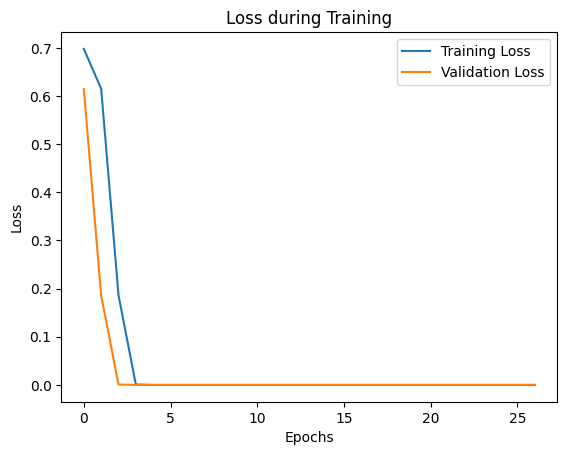

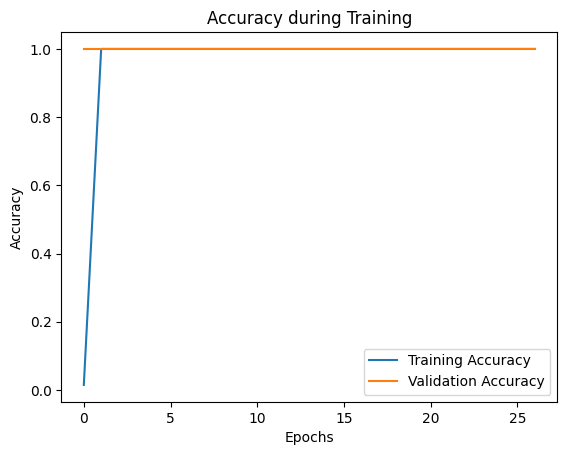

In [18]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def create_unet(input_shape=(256, 256, 4)):
    """
    Create basic U-Net model
    """
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bridge
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


# Create model
model = create_unet(input_shape=(256, 256, 4))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
model.save('unet_deforestation_model.h5')

# Evaluate
results = model.evaluate(X_val, y_val)
loss = results[0]
accuracy = results[1]
print(f"Validation loss: {loss}, Validation accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - io_u: 1.0000 - loss: 3.7324e-23
Validation loss: 3.7323672620422095e-23, Validation accuracy: 1.0


In [21]:
# Predict on the validation dataset
predicted_masks = model.predict(X_val)

# Threshold the predictions to get binary masks (0 or 1)
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

print(f"Predicted masks shape: {predicted_masks.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Predicted masks shape: (4, 256, 256, 1)


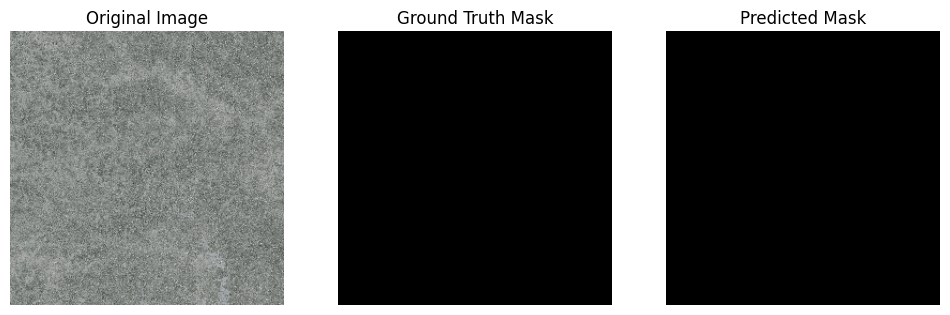

In [22]:
import matplotlib.pyplot as plt

def plot_sample(image, ground_truth, prediction, index):
    """
    Plot a single image with its ground truth mask and predicted mask.
    Args:
        image: The original image (input to the model).
        ground_truth: The ground truth mask (label).
        prediction: The predicted mask from the model.
        index: Index of the image to visualize.
    """
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image[index])
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth[index], cmap="gray")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction[index], cmap="gray")
    plt.axis("off")

    plt.show()

# Example: Plot the first sample
plot_sample(X_val, y_val, predicted_masks, index=0)

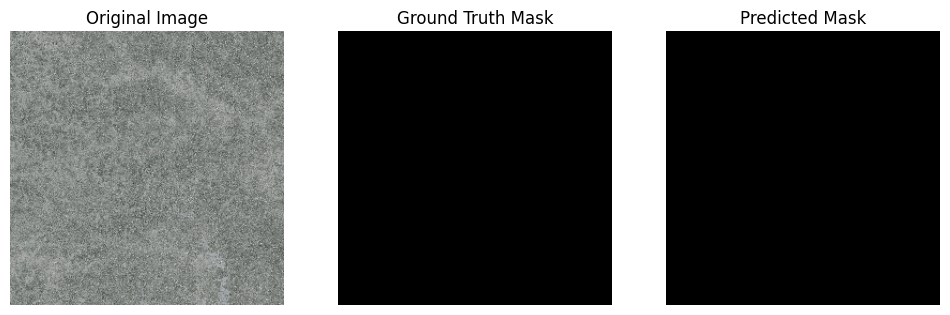

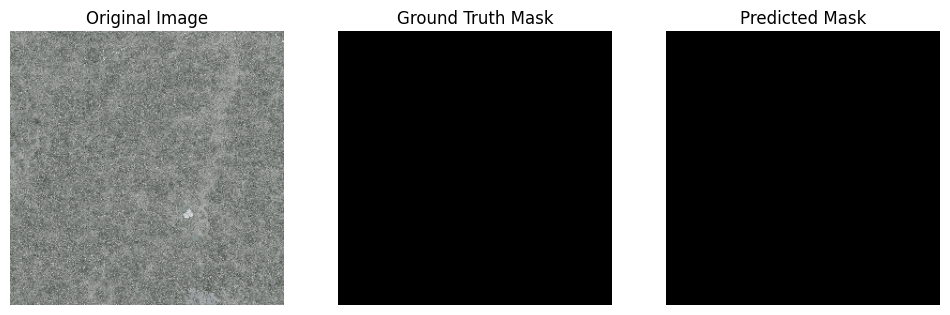

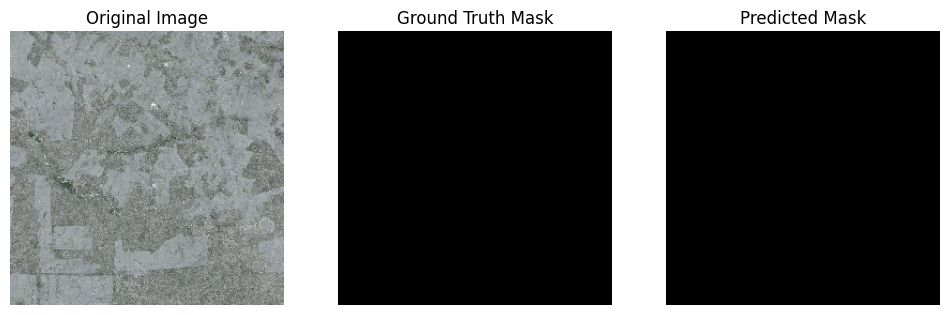

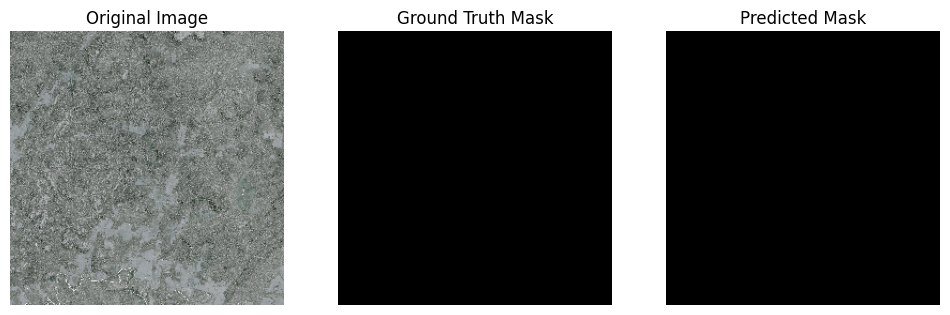

In [23]:
def plot_multiple_samples(images, ground_truths, predictions, num_samples=5):
    """
    Plot multiple images with their ground truth and predicted masks.
    Args:
        images: Array of input images.
        ground_truths: Array of ground truth masks.
        predictions: Array of predicted masks.
        num_samples: Number of samples to visualize.
    """
    # Use the minimum of num_samples or the number of available samples
    num_samples = min(num_samples, len(images))
    
    for i in range(num_samples):
        plot_sample(images, ground_truths, predictions, index=i)

# Plot the first 5 samples (adjusting for available data size)
plot_multiple_samples(X_val, y_val, predicted_masks, num_samples=5)

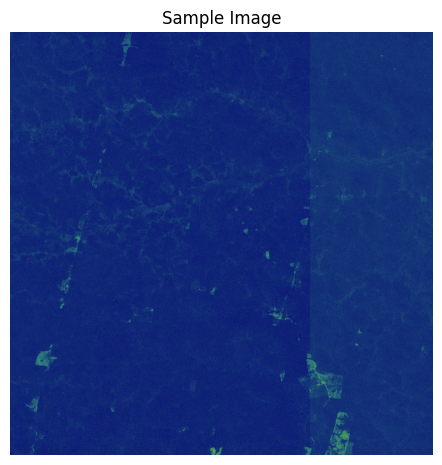

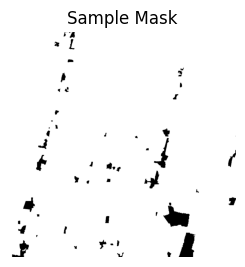

In [25]:
import matplotlib.pyplot as plt
from skimage.io import imread

# Load a sample image and mask
sample_image = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/RASTER_0.tif'
sample_mask = imread('/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/3_TRAINING_MASKS/MASK_16_GRID/RASTER_0.tif')

# Plot sample image and mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
with rasterio.open(sample_image) as src:
    image = src.read(1)  # Read the first band
    plt.imshow(image, cmap='gist_earth')
    plt.title("Sample Image")
    plt.axis('off')
    plt.show()

plt.subplot(1, 2, 2)
plt.title("Sample Mask")
plt.imshow(sample_mask, cmap='gray')
plt.axis('off')

plt.show()

Image shape: (11264, 11264, 4)


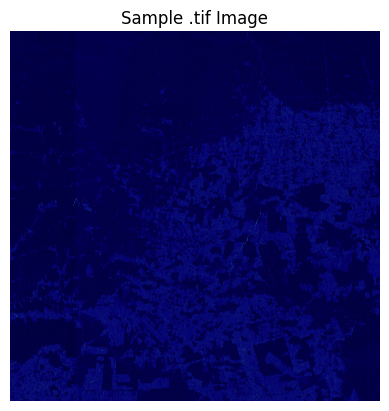

In [26]:
image_path = '/home/epele/.cache/kagglehub/datasets/akhilchibber/deforestation-detection-dataset/versions/1/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_FULL/raster.tif'
sample_image = imread(image_path)
print(f"Image shape: {sample_image.shape}")

with rasterio.open(image_path) as src:
    image = src.read(1)  # Read the first band
    plt.imshow(image, cmap='gist_earth')
    plt.title("Sample .tif Image")
    plt.axis('off')
    plt.show()

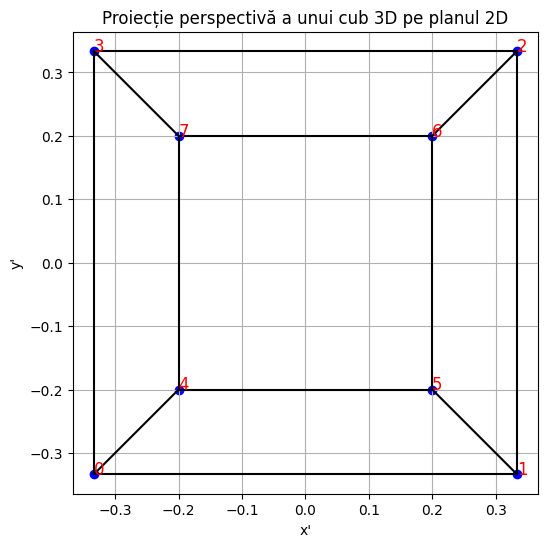

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Definim punctele unui cub în spațiul 3D.
# Cubul are o față la z = 3 și cealaltă la z = 5.
points = np.array([
    [-1, -1, 3],
    [ 1, -1, 3],
    [ 1,  1, 3],
    [-1,  1, 3],
    [-1, -1, 5],
    [ 1, -1, 5],
    [ 1,  1, 5],
    [-1,  1, 5]
])

# Funcția de proiecție simplă: aplică formula x' = (d*x)/z, y' = (d*y)/z.
def project(point, d=1):
    x, y, z = point
    return np.array([d * x / z, d * y / z])

# Proiectăm toate punctele cubului.
projected_points = np.array([project(p, d=1) for p in points])

# Configurăm graficul.
plt.figure(figsize=(6,6))
plt.scatter(projected_points[:,0], projected_points[:,1], color='blue')
for i, p in enumerate(projected_points):
    plt.text(p[0], p[1], str(i), color='red', fontsize=12)

# Definim muchiile cubului pentru a-l desena corect.
edges = [
    (0,1), (1,2), (2,3), (3,0),  # fața din față
    (4,5), (5,6), (6,7), (7,4),  # fața din spate
    (0,4), (1,5), (2,6), (3,7)   # muchiile laterale
]

# Desenăm muchiile cubului.
for e in edges:
    p1 = projected_points[e[0]]
    p2 = projected_points[e[1]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-')

plt.xlabel("x'")
plt.ylabel("y'")
plt.title("Proiecție perspectivă a unui cub 3D pe planul 2D")
plt.grid(True)
plt.axis('equal')
plt.show()
